# TIM - TP 6 : Un peu de couleurs en cette période grise...

Aujourd'hui, on oublie les images en niveaux de gris, et on passe aux images couleurs. Pourquoi passer à la couleur ? Pourquoi abandonner les images en niveaux de gris ? Que nous cache Lena en couleur ? Vous le saurez aujourd'hui dans ce TP....

In [1]:
# Chargement des librairies
import cv2
from matplotlib import pyplot as plt
import numpy as np
# %matplotlib widget

path_base = "../Base_images/"

## Ex. 0 : Comment ça ? Il y a d'autres espaces de couleurs autres que RGB ?

Et oui ! On connaît le fameux espace de couleur RGB, mais il en existe plein d'autres. Pour ce TP, on va en découvrir quelques uns. Mais d'abord, choississons une image couleur à étudier (crayons.jpg aujourd'hui). Chargez là, et affichez la (attention, je veux obligatoirement du RGB !!)

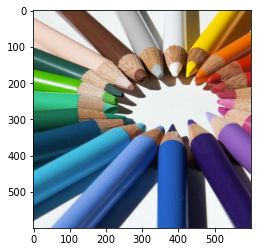

In [2]:
bgr_image = cv2.imread(path_base+"crayons.jpg",1)
rgb_image = cv2.cvtColor(bgr_image,cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)

Durant ce TP, nous allons découvrir plusieurs espaces de couleurs, leur utilité et leurs particularités. Vous vous en doutez, OpenCV fait tout, et notamment les conversions dans différents espaces de couleur. Maintenant, comme c'est un TP, je vais vous demander donc de développer les conversions vous-même, mais on fera une comparaison avec les conversions via OpenCV.

## Ex. 1 : CMYK, on commence tranquille

Commençons avec l'espace de couleur CMYK (pour Cyan, Magenta, Yellow et blacK). Celui-ci, vous le connaissez, c'est utilisé pour les impressions. Le principe, c'est que contrairement, ou la synthèse est additive (toutes les composantes R, G et B en quantité maximale donne la couleur blanche); ici, la synthèse est soustractive (toutes les composantes C, M et Y en quantité maximale donne la couleur noire). La dernière composante, noire, permet tout simplement de minimiser les composantes couleurs, plus chères que la composante noire lors de l'impression.

La conversion n'est pas disponible via OpenCV, mais elle reste assez simple pour autant, avec r, g et b les composantes Red, Green et Blue normalisées (float entre 0 et 1) :

\begin{equation*}
k = 1-max(r,g,b) \\
c = 1-r-k \\
m = 1-g-k \\
y = 1-b-k \\
\end{equation*}


In [3]:
# A compléter
# Fonction de conversion de l'image RGB en CMYK
def RGBtoCMYK(rgb_image):
    (h,w,_) = rgb_image.shape
    # Normalisation
    rgb_image = rgb_image/255.
    #print(np.unique(rgb_image))
    cmyk_image = np.zeros((h,w,4),dtype=np.float)
    # Channel K
    cmyk_image[:,:,3] = 1 - np.max(rgb_image,axis=2)
    # Channel C
    cmyk_image[:,:,0] = (np.ones((h,w))-rgb_image[:,:,0]-cmyk_image[:,:,3])
    # Channel M
    cmyk_image[:,:,1] = (np.ones((h,w))-rgb_image[:,:,1]-cmyk_image[:,:,3])
    # Channel Y
    cmyk_image[:,:,2] = (np.ones((h,w))-rgb_image[:,:,2]-cmyk_image[:,:,3])
    
    return np.round(cmyk_image*255).astype(np.uint8)

cmyk_image = RGBtoCMYK(rgb_image)

Affichez le résultat channel par channel. Attention, ici, on va affichez le résultat comme dans le cadre d'une impression : notre image est donc à la base blanche, et on affichera chaque channel en soustrayant celui-ci à la "feuille blanche".

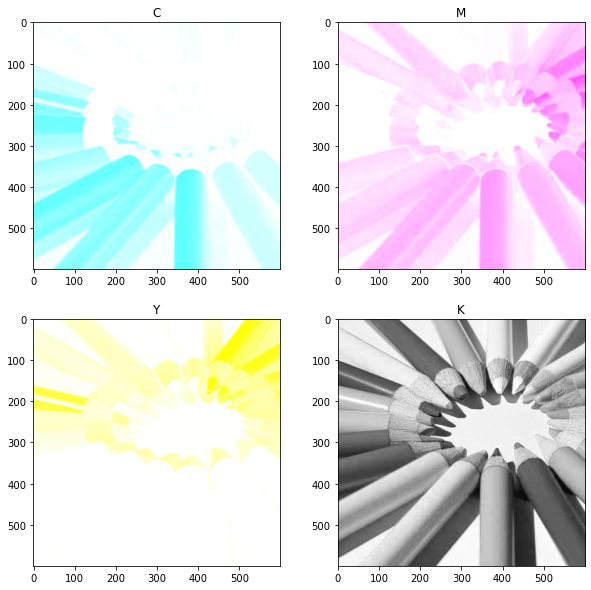

In [4]:
# A compléter
# Affichage du résultat channel par channel sur une "feuille blanche"
feuille_blanche = np.ones(rgb_image.shape,dtype=np.uint8)*255
plt.subplots(2,2,figsize=(10,10))
# Composante C
composante_c = feuille_blanche.copy()
composante_c[:,:,0]=composante_c[:,:,0]-cmyk_image[:,:,0]
plt.subplot(221)
plt.imshow(composante_c)
plt.title("C")
# Composante M
composante_m = feuille_blanche.copy()
composante_m[:,:,1]=composante_m[:,:,1]-cmyk_image[:,:,1]
plt.subplot(222)
plt.imshow(composante_m)
plt.title("M")
# Composante Y
composante_y = feuille_blanche.copy()
composante_y[:,:,2]=composante_y[:,:,2]-cmyk_image[:,:,2]
plt.subplot(223)
plt.imshow(composante_y)
plt.title("Y")
# Composante K
composante_k = feuille_blanche.copy()
composante_k=composante_k-np.stack([cmyk_image[:,:,3] for i in range(3)],axis=2)
plt.subplot(224)
plt.imshow(composante_k)
plt.title("K")
plt.show()

Et pour finir tranquillement cet exercice, recréez l'image RGB de base à partir de la "feuille blanche" et des composantes C, M, Y et K à soustraire.

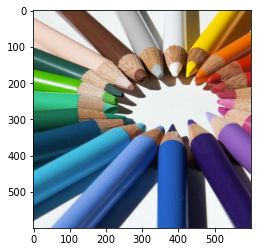

In [5]:
# A compléter
# Affichage de la feuille imprimée (feuille blanche où on retire les composantes C,M,Y et K)
feuille_imprimée = feuille_blanche.copy()
feuille_imprimée=feuille_imprimée-np.stack([cmyk_image[:,:,3] for i in range(3)],axis=2)
feuille_imprimée=feuille_imprimée-cmyk_image[:,:,0:3]
plt.imshow(feuille_imprimée)

## Ex. 2 : YUV

Continuons ce TP avec l'espace de couleur YUV. Cet espace de couleurs a été conçu en 1960 pour une raison très précise. A cette époque, les premières télévisions couleurs apparaissent, et les chaînes de télévision doivent donc envoyer un signal pour 2 types de télévisions différentes : les télévisions couleurs et les télévisions Noir et Blanc. Cependant, les plus anciennes télévisions ne sont pas adaptées pour traiter un signal différent que ceux qu'elles recevaient avant : on ne peut donc envoyer un signal style RGB et faire la conversion en N&B à la réception. Pour cela, il fallait envoyer un signal comprenant l'info en niveau de gris, comme auparavant, mais avec des autres composantes pour afficher la couleur pour les télévisions qui le peuvent. 

Pour cela, l'espace de couleur YUV a été créé. Il est composé d'une composante luminance (Y) contenant l'information en N&B, et 2 composantes chrominances (U et V) contenant l'information couleur. Par exemple, dans la plage suivante, les composantes U et V permettent de caractériser ces couleurs, pour Y = 0.5. Ce que cela veut dire, c'est que toutes ces couleurs converties en N&B donneront uniquement 0.5, soit Y.

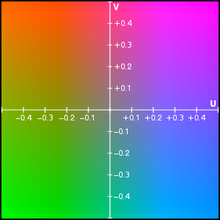

Pour ce faire, on va utiliser les formules suivantes, avec r, g et b les composantes Red, Green et Blue normalisées (float entre 0 et 1) :
\begin{equation*}
y = r + g + b \\
u = b - y \\
v = r - y
\end{equation*}

*_Note :_* si vous n'avez pas le même résultat qu'OpenCV, c'est normal : on utilise une version très simplifiée, sans applicateurs correctifs. La version d'OpenCV, nettement améliorée, permet d'obtenir un channel Y (niveaux de gris) beaucoup plus fidèle que pour notre version.

In [6]:
# A compléter
# Fonction de conversion manuelle de l'image RGB en YUV
def RGBtoYUV(rgb_image):
    rgb_image = rgb_image/255.
    yuv_image = np.zeros(rgb_image.shape,dtype=np.float)
    yuv_image[:,:,0]=np.sum(rgb_image,axis=-1)
    yuv_image[:,:,1]=rgb_image[:,:,2]-yuv_image[:,:,0]
    yuv_image[:,:,2]=rgb_image[:,:,0]-yuv_image[:,:,0]
    return yuv_image

yuv_image=RGBtoYUV(rgb_image)

In [7]:
# A compléter
# Conversion de l'image RGB en YUV via OpenCV
real_yuv_image = cv2.cvtColor(rgb_image,cv2.COLOR_RGB2YUV)

Affichez le résultat channel par channel des résultats obtenus.

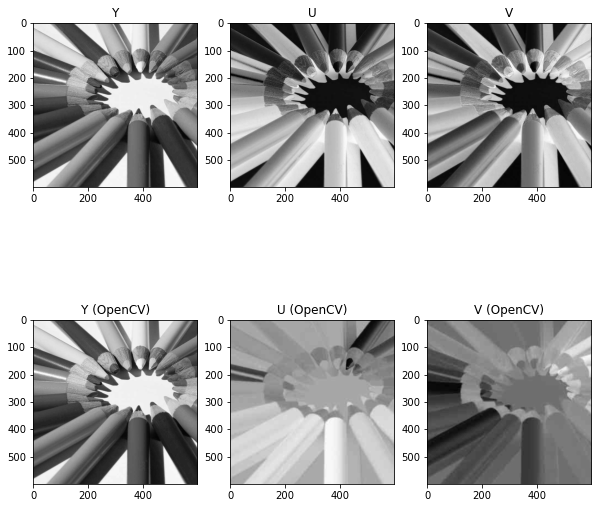

In [8]:
# A compléter
# Affichage des résultats channel par channel
plt.subplots(2,3,figsize=(10,10))
plt.subplot(231)
plt.imshow(yuv_image[:,:,0],'gray')
plt.title('Y')
plt.subplot(232)
plt.imshow(yuv_image[:,:,1],'gray')
plt.title('U')
plt.subplot(233)
plt.imshow(yuv_image[:,:,2],'gray')
plt.title('V')
plt.subplot(234)
plt.imshow(real_yuv_image[:,:,0],'gray')
plt.title('Y (OpenCV)')
plt.subplot(235)
plt.imshow(real_yuv_image[:,:,1],'gray')
plt.title('U (OpenCV)')
plt.subplot(236)
plt.imshow(real_yuv_image[:,:,2],'gray')
plt.title('V (OpenCV)')
plt.show()

Si tout va bien, on peut voir que visuellement, les channels Y de nos 2 résultats se ressemblent pas mal, ce qui nous conviendra. Maintenant, l'objectif va être de recréer l'image RGB à partir de l'image YUV que nous avons calculé auparavant, comme le faisaient les télévisions couleurs à l'ancienne époque.

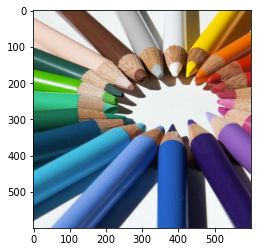

In [9]:
# A compléter
# Conversion manuelle de l'image YUV en RGB et affichage du résultat
rgb_from_yuv_image = np.zeros(yuv_image.shape,dtype = np.float)
rgb_from_yuv_image[:,:,0]=yuv_image[:,:,0]+yuv_image[:,:,2]
rgb_from_yuv_image[:,:,1]=-yuv_image[:,:,0]-yuv_image[:,:,1]-yuv_image[:,:,2]
rgb_from_yuv_image[:,:,2]=yuv_image[:,:,0]+yuv_image[:,:,1]
rgb_from_yuv_image = np.clip(np.round(rgb_from_yuv_image*255),0,255).astype(np.uint8)
plt.imshow(rgb_from_yuv_image)

## Ex. 3 : HSV

Poursuivons avec l'espace de couleur HSV (pour Hue, Saturation et Value) ou TSI en français (Teinte, Saturation, Intensité). Comme RGB, on a également 3 channels définis de la manière suivante :
- La teinte (Hue) est codée suivant l'angle qui lui correspond sur le cercle des couleurs (de 0 à 360°).
- La saturation (Saturation) est l'intensité de la couleur (de 0 à 100%).
- La valeur (Value) est la brillance de la couleur (de 0 à 100%).

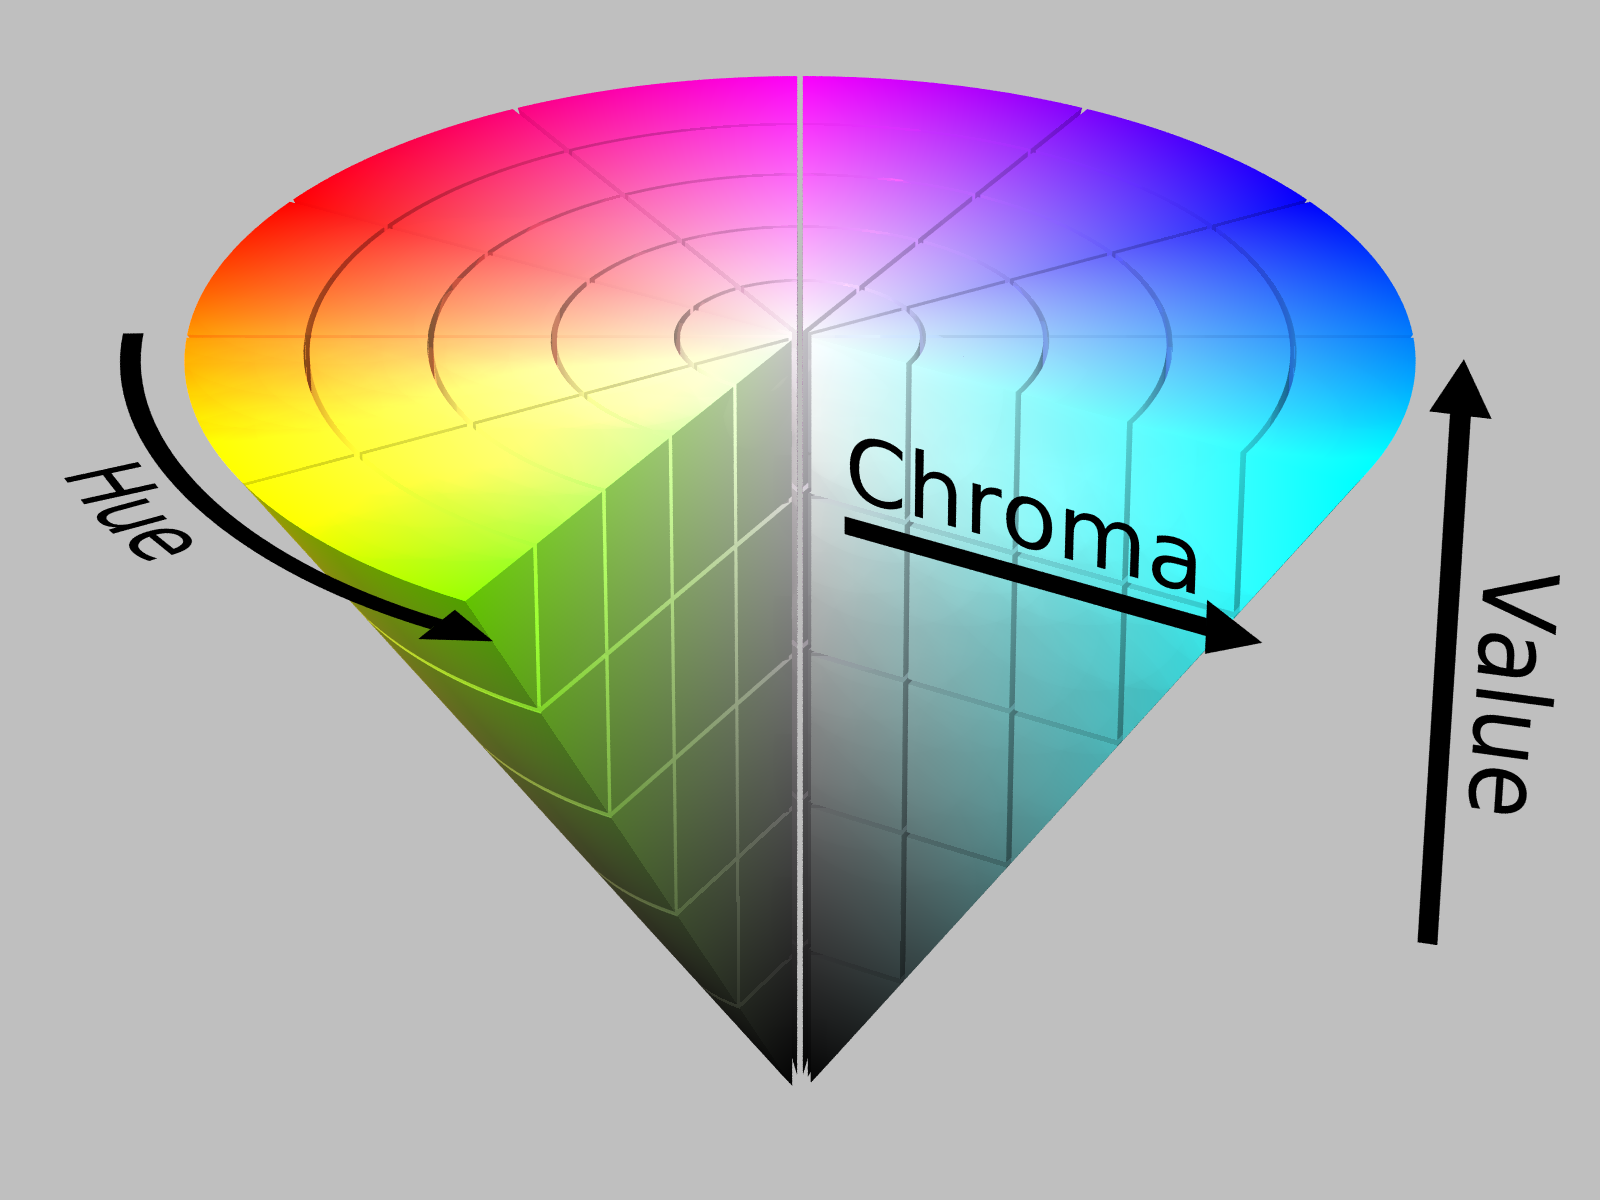

On peut convertir une image RGB en image HSV grâce aux formules suivantes (r,g,b sont respectivement les channels Red, Green et Blue normalisés de notre image RGB ; h,s,v sont les channels Hue, Saturation et Value normalisés de notre image HSV) :

\begin{equation*}
max\_rgb = max(r,g,b) \\
\end{equation*}


\begin{equation*}
min\_rgb = min(r,g,b) \\
\end{equation*}



h=
\begin{cases}
0, & si \max = \min \\
(60^\circ \times \frac{g - b}{\max - \min} + 360^\circ)\;\bmod\;360^\circ,   & si \max = r \\
60^\circ \times \frac{b - r}{\max - \min} + 120^\circ, & si \max = g \\
60^\circ \times \frac{r - g}{\max - \min} + 240^\circ, & si \max = b \\
\end{cases} \\

s = 
\begin{cases}
0, & si \max = 0 \\
1 - \frac {\min} {\max}, & sinon
\end{cases} \\
v = max\_rgb

Notez juste que dans le cadre de notre implémentation, il faudra également qu'on divise notre channel h par 2 pour avoir une valeur entre 0 et 180° (histoire d'avoir nos images codées en uint8).

Réalisez la conversion manuellement, puis avec OpenCV (cvtColor, toi-même tu sais).

In [10]:
# A compléter
# Transformation de l'image RGB en HSV (manuel)
def RGBtoHSV(rgb_image):
    h,w,c = rgb_image.shape
    rgb_image = rgb_image/255.0
    max_rgb = np.max(rgb_image,axis=2)
    min_rgb = np.min(rgb_image,axis=2)
    
    hsv = np.zeros(rgb_image.shape)
    hsv[:,:,2]=max_rgb*255
    hsv[:,:,1][max_rgb!=0] = (np.ones((h,w))[max_rgb!=0]-(min_rgb/max_rgb)[max_rgb!=0])*255
    mask_r = np.bitwise_and(max_rgb==rgb_image[:,:,0],max_rgb!=min_rgb)
    mask_g = np.bitwise_and(max_rgb==rgb_image[:,:,1],max_rgb!=min_rgb)
    mask_b = np.bitwise_and(max_rgb==rgb_image[:,:,2],max_rgb!=min_rgb)
    hsv[:,:,0][mask_r] = ((60*((rgb_image[:,:,1][mask_r]-rgb_image[:,:,2][mask_r])/(max_rgb[mask_r]-min_rgb[mask_r])))%360)/2
    hsv[:,:,0][mask_g] = (60*((rgb_image[:,:,2][mask_g]-rgb_image[:,:,0][mask_g])/(max_rgb[mask_g]-min_rgb[mask_g]))+120)/2
    hsv[:,:,0][mask_b] = (60*((rgb_image[:,:,0][mask_b]-rgb_image[:,:,1][mask_b])/(max_rgb[mask_b]-min_rgb[mask_b]))+240)/2
    return np.clip(np.round(hsv),0,255).astype(np.uint8)
hsv_image = RGBtoHSV(rgb_image)

In [11]:
# A compléter
# Transformation de l'image RGB en HSV avec OpenCV
real_hsv_image = cv2.cvtColor(rgb_image,cv2.COLOR_RGB2HSV)

Affichez les 2 résultats obtenus, en couleur et channel par channel (en niveau de gris).

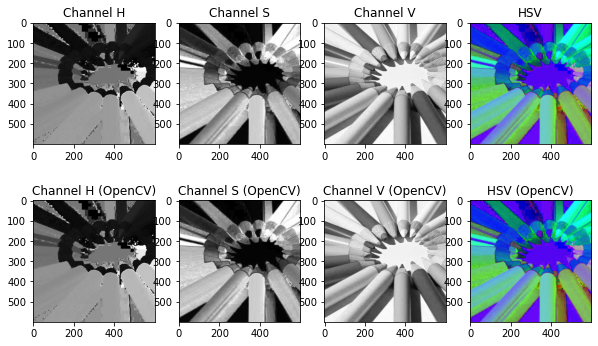

In [12]:
# A compléter
# Affichage des résultats obtenus channel par channel et en couleur (manuelle et OpenCV)
plt.subplots(2,4,figsize=(10,6))
plt.subplot(241)
plt.imshow(hsv_image[:,:,0],'gray')
plt.title("Channel H")
plt.subplot(242)
plt.imshow(hsv_image[:,:,1],'gray')
plt.title("Channel S")
plt.subplot(243)
plt.imshow(hsv_image[:,:,2],'gray')
plt.title("Channel V")
plt.subplot(244)
plt.imshow(hsv_image)
plt.title("HSV")
plt.subplot(245)
plt.imshow(real_hsv_image[:,:,0],'gray')
plt.title("Channel H (OpenCV)")
plt.subplot(246)
plt.imshow(real_hsv_image[:,:,1],'gray')
plt.title("Channel S (OpenCV)")
plt.subplot(247)
plt.imshow(real_hsv_image[:,:,2],'gray')
plt.title("Channel V (OpenCV)")
plt.subplot(248)
plt.imshow(real_hsv_image)
plt.title("HSV (OpenCV)")
plt.show()

# Ex 4. : Wololo !

Bon là, c'est pas du tout un nouvel espace de couleur, c'est juste un titre d'exo... Chargez l'image iron_man.jpg et affichez-la (EN RGB !).

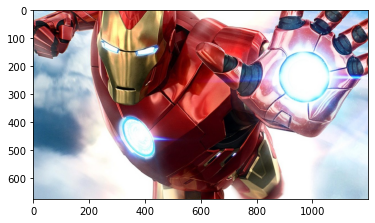

In [17]:
# A compléter
# Chargement et affichage de l'image iron_man.jpg
iron_man = cv2.cvtColor(cv2.imread(path_base+'iron_man.jpg',-1),cv2.COLOR_BGR2RGB)
plt.imshow(iron_man)
plt.show()

J'ai un caprice : je n'aime pas le rouge. C'est la seule chose que je déteste dans ce monde : la couleur rouge. J'aimerai que Iron Man ne soit plus rouge mais bleu. Par contre, j'aime le jaune, donc je veux qu'on garde la couleur jaune. Et le bleu, je veux qu'il reste bleu aussi... On garde tout, sauf le rouge, qu'on va mettre en bleu.

Pour résumé : l'objectif de cet exercice va être de sélectionner les pixels rouges de l'image Iron Man et les mettre en bleus, tout en faisant que l'image reste naturelle. Je vous laisse la liberté de faire comme vous le souhaitez, mais je vous recommande fortement de revoir l'exercice 3 si le message passé n'est pas clair...

Pour réaliser cet exercice, on peut le diviser en 2 parties : la sélection des pixels rouges, et ensuite le changement de teinte de ces pixels.

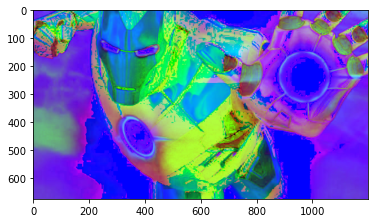

In [18]:
# Conversion de l'image RGB en HSV
hsv_iron_man = cv2.cvtColor(iron_man,cv2.COLOR_RGB2HSV)
plt.imshow(hsv_iron_man)

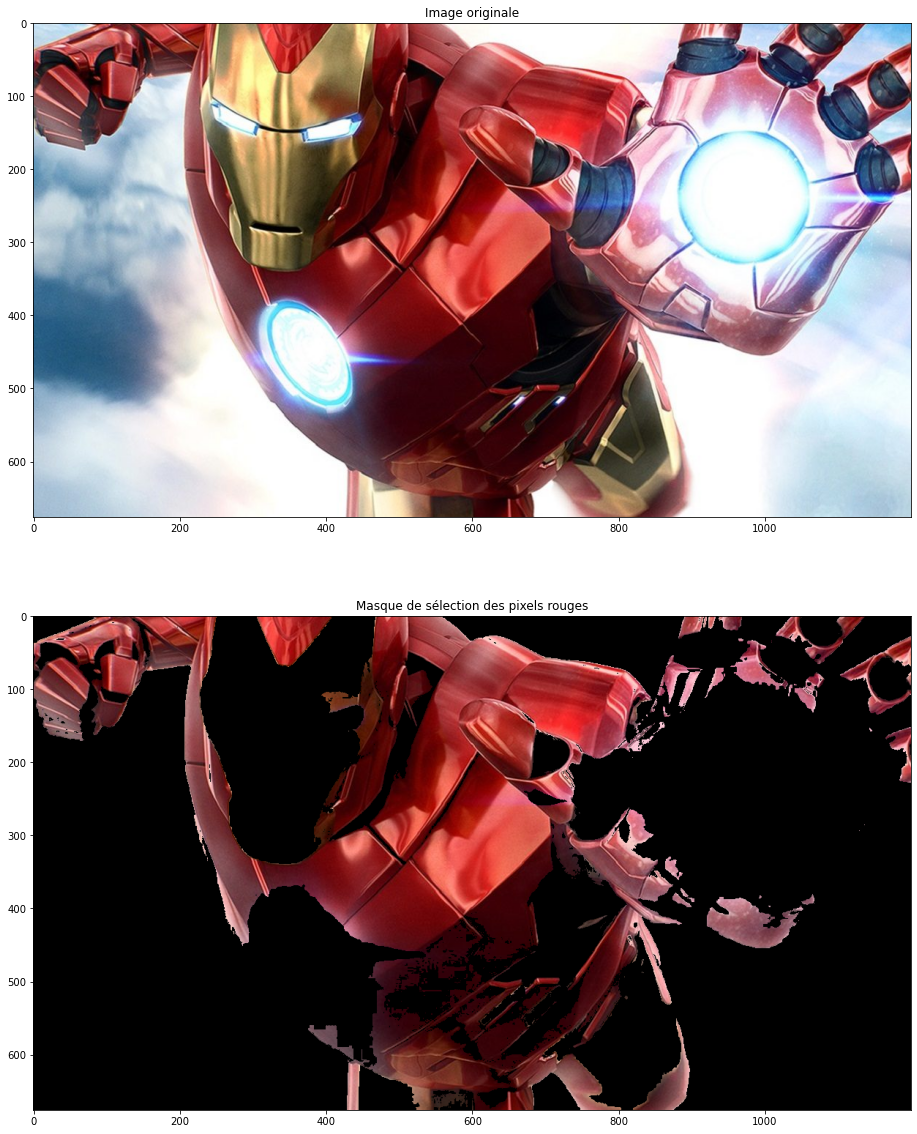

In [19]:
# On peut considérer les pixels de teinte rouge comme des pixels ayant des valeurs H dans l'intervalle [-20,20]. 
# Comme on divise le channel H par 2 pour rester en données uint8, l'intervalle passe donc à [-10,10].
# Cependant, c'est du uint8, donc les valeurs sont comprises entre [0 et 180°].
# Les pixels de teinte rouge ont donc dans notre image des valeurs entre 0° et 10°, ou entre 170 et 180°.
# On va donc devoir créer deux masques de sélections, et les additionner.

# Création d'un masque de sélection des valeurs rouges entre 0 et 10°
lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])
mask0 = cv2.inRange(hsv_iron_man, lower_red, upper_red).astype(np.bool)

# Création d'un masque de sélection des valeurs rouges entre 170 et 180°
lower_red = np.array([170,50,50])
upper_red = np.array([180,255,255])
mask1 = cv2.inRange(hsv_iron_man, lower_red, upper_red).astype(np.bool)

# Addition des deux masques pour avoir la sélection des valeurs rouges entre 0 et 10°, ou entre 170 et 180°.
mask = mask0+mask1

# Création d'une représentation du masque de sélection pour affichage
res = np.zeros(iron_man.shape,dtype=np.uint8)
res[mask]=iron_man[mask]

# Affichage des résultats
plt.subplots(2,1,figsize=(20,20))
plt.subplot(211)
plt.imshow(iron_man)
plt.title("Image originale")
plt.subplot(212)
plt.imshow(res)
plt.title("Masque de sélection des pixels rouges")
plt.show()

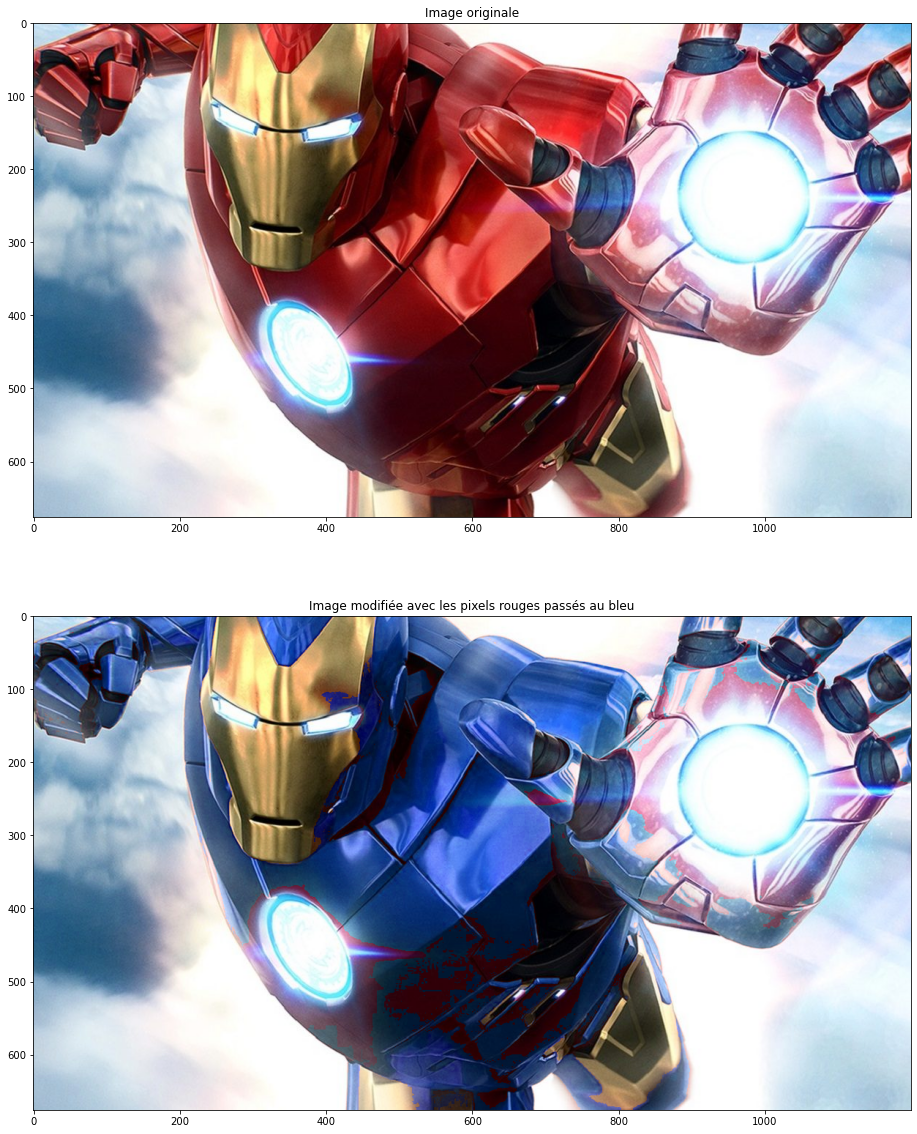

In [20]:
# Changement de couleur des pixels de teinte rouge en teinte bleu (on ajoute 110° à leurs valeurs du channel H, sans toucher à S et V).
output = hsv_iron_man.copy()
output[mask]=((output[mask].astype(np.uint16)+[110,0,0])%[180,256,256]).astype(np.uint8)

# Affichage des résultats
plt.subplots(2,1,figsize=(20,20))
plt.subplot(211)
plt.imshow(iron_man)
plt.title("Image originale")
plt.subplot(212)
plt.imshow(cv2.cvtColor(output,cv2.COLOR_HSV2RGB))
plt.title("Image modifiée avec les pixels rouges passés au bleu")
plt.show()